# 🏦 GESTÃO DE RISCO: MODELO DE SCORING BASILEIA (PD)
*## 1. Arquitetura de Governança e Inicialização do Pipeline
Este bloco estabelece as fundações de infraestrutura do projeto, garantindo reprodutibilidade e modularidade do código em qualquer ambiente (Local ou Nuvem).

**Fundamentos de Engenharia de Dados:**
1. **Hot Reloading Automático (`%autoreload`):** Garante que qualquer alteração nos scripts base (`src/*.py`) seja injetada na memória RAM instantaneamente, prevenindo a execução de funções em *cache* desatualizado (Risco de Infraestrutura).
2. **Pathfinding Dinâmico (`Path.cwd`):** Blindagem do GPS de diretórios. Evita o colapso do código (*FileNotFoundError*) ao transitar o projeto entre diferentes máquinas ou servidores do banco.
3. **Visor Financeiro (`float_format`):** Padronização da leitura de matrizes para notação financeira (4 casas decimais), suprimindo a notação científica que mascara passivos em volumetrias altas.

In [2]:
# ===================================================================
# CÉLULA 1: INICIALIZAÇÃO, INGESTÃO E HIGIENE COMPLETA (V2)
# ===================================================================
%load_ext autoreload
%autoreload 2

import sys, pandas as pd, numpy as np
from pathlib import Path

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

raiz = Path.cwd() if Path.cwd().joinpath('src').exists() else Path.cwd().parent
sys.path.append(str(raiz))

from src.data_ingestion import carregar_base_basileia
from src.feature_engineering import (
    definir_variavel_alvo, 
    remover_colunas_toxicas, 
    imputar_dados_nulos, 
    categorizar_renda_dti, 
    dividir_treino_teste,
    padronizar_tempo_emprego,    
    calcular_historico_credito,
    padronizar_home_ownership
)

# Gaveta da Matemática
from src.woe_iv import calcular_woe_iv, injetar_woe_na_base
from src.plots_woe import auditar_tendencia_woe, auditar_curva_roc

#  Gaveta de Escalonamento
from src.scorecard_scaler import calcular_score_final, aplicar_politica_decisao_original, aplicar_politica_decisao_quartis, simular_politica_selic

print("STATUS: Iniciando Ingestão de Dados e Protocolo de Trauma...")

loan_data = carregar_base_basileia()
loan_data = definir_variavel_alvo(loan_data)
loan_data = padronizar_home_ownership(loan_data)

# TRATAMENTO DE CHOQUE (Limpeza)
loan_data = remover_colunas_toxicas(loan_data, limite_toxicidade=0.50)
loan_data = imputar_dados_nulos(loan_data)

# ENGENHARIA DE FEATURES (Resgatando as Variáveis Fantasmas)
# 1. Aplicando a inteligência temporal que estava esquecida
loan_data['emp_length_num'] = padronizar_tempo_emprego(loan_data)
loan_data['meses_historico_credito'] = calcular_historico_credito(loan_data, 'issue_d')

# 2. Aplicando a inteligência FGV e Filtro de 18k
loan_data = categorizar_renda_dti(loan_data)

print(f"STATUS: Cockpit do V2 alinhado. Total de CPFs: {len(loan_data)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
STATUS: Iniciando Ingestão de Dados e Protocolo de Trauma...
STATUS: Rota confirmada. Iniciando leitura de loan_data_2007_2014.csv...
SUCESSO: 466285 linhas extraídas para a RAM.
STATUS: Cockpit do V2 alinhado. Total de CPFs: 466285


## 2. Esteira ETL V2: Higiene e Abrasileiramento (Feature Engineering)
Este é o motor principal de tratamento de dados. Ele extrai a base bruta, limpa a Dívida Técnica e transforma as *features* em uma matriz matemática de risco auditável.

**Fundamentos Matemáticos e de Negócio:**
1. **A Bússola de Risco (Target):** Criação da variável binária `good_bad_loan` operando em baixo nível via `np.where`.
   * **1 (Lucro):** Clientes adimplentes (*Current, Fully Paid*).
   * **0 (Loss / PD):** Clientes em default (*Charged Off, Late > 31 dias*). Representam o alvo da nossa modelagem.
2. **Remoção de Ativos Tóxicos e Imputação:** Variáveis com excesso de dados nulos (NaN) são ejetadas (*Drop*). Tentar imputar dados com >50% de ausência configuraria fraude estatística (distorção severa da variância). Nulos tratáveis recebem *proxies* conservadores.
3. **Filtro de Sobrevivência (Higiene V2):** Exclusão sumária de registros com `annual_inc` < R$ 18.356 (1 Salário Mínimo). Previne a contaminação do motor por erros operacionais de preenchimento na captação da agência.
4. **Governança Socioeconômica (FGV & DTI):** Vetorização da renda bruta em Classes Sociais (A até E) e enquadramento do DTI em faixas de Margem Consignável. Elimina a variância infinita de valores contínuos e cria "gavetas" de risco compreensíveis para o Comitê Comercial.

In [3]:
# ===================================================================
# CÉLULA 2: AUDITORIA DE DÍVIDA TÉCNICA (NULOS)
# ===================================================================

print("STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...")

# 1. A Matemática do Rombo
total_linhas = len(loan_data)
nulos_abs = loan_data.isnull().sum()
nulos_perc = (nulos_abs / total_linhas) * 100

# 2. A Construção do Balanço Patrimonial (DataFrame limpo)
relatorio_nulos = pd.DataFrame({
    'Total_Vazios': nulos_abs,
    'Percentual (%)': nulos_perc
})

# 3. O Filtro de Toxicidade: Queremos ver apenas quem tem rombo, do pior (maior %) para o melhor
relatorio_nulos = relatorio_nulos[relatorio_nulos['Total_Vazios'] > 0].sort_values(by='Percentual (%)', ascending=False)

print(f"ALERTA: O radar detectou {len(relatorio_nulos)} variáveis com dados faltantes na fuselagem.\n")
display(relatorio_nulos.head(15)) # Imprime as 15 variáveis mais tóxicas

STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...
ALERTA: O radar detectou 19 variáveis com dados faltantes na fuselagem.



,Total_Vazios,Percentual (%)
next_pymnt_d,227214,48.7286
tot_cur_bal,70276,15.0715
tot_coll_amt,70276,15.0715
emp_title,27588,5.9166
emp_length,21008,4.5054
emp_length_num,21008,4.5054
last_pymnt_d,376,0.0806
revol_util,340,0.0729
collections_12_mths_ex_med,145,0.0311
last_credit_pull_d,42,0.0090


## 3. Auditoria de Sanidade da Matriz (Dívida Técnica)
O algoritmo de Regressão Logística exige matrizes densas e completas. A presença de *NaNs* (Not a Number) resulta em falha de compilação ou omissão de cálculo de probabilidade.

**Fundamentos Estatísticos:**
1. **Mapeamento de Rombo:** Varredura vetorial (`isnull().sum()`) para identificar vazamentos de dados após o processamento do ETL.
2. **Risco Operacional:** Uma base de dados aprovada para treinamento deve registrar $0.00\%$ de Dívida Técnica nas variáveis preditoras. Qualquer valor residual indica quebra de linhagem (*Data Lineage*) na etapa anterior.

In [4]:
# ===================================================================
# CÉLULA 2.5: AUDITORIA DE HIGIENE (RENDA ANUAL)
# ===================================================================
print("STATUS: Auditando a sanidade da Renda após o filtro de Sobrevivência...\n")

# O Diretor quer ver se realmente cortamos a base da pirâmide extrema
resumo_renda = loan_data['annual_inc'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
display(resumo_renda.to_frame().T)

print("\nLAUDO DO AUDITOR: Se o valor 'min' for >= 18356, a base está blindada contra lixo operacional.")

STATUS: Auditando a sanidade da Renda após o filtro de Sobrevivência...



,count,mean,std,min,5%,25%,50%,75%,95%,max
annual_inc,466281.0000,73277.3815,54963.5687,1896.0000,28000.0000,45000.0000,63000.0000,88960.0000,150000.0000,7500000.0000



LAUDO DO AUDITOR: Se o valor 'min' for >= 18356, a base está blindada contra lixo operacional.


## 4. Particionamento Estocástico de Safra (Train/Test Split)
Divisão da matriz em dois universos paralelos para forjar o modelo em um ambiente e validá-lo em outro, simulando o comportamento de produção (base *Out-of-Time / Holdout*).

**Fundamentos Matemáticos e de Negócio:**
1. **Isolamento da Variável Alvo:** Separação do Histórico (Matriz $X$) da Resposta (Vetor $y$). 
2. **Prevenção de Data Leakage:** A transformação da base deve ocorrer estritamente *após* o fatiamento. O cálculo de propensão usando a base de teste contaminaria o treino, permitindo que o modelo "veja o futuro" e gere uma correlação espúria perfeita ($R^2 = 1.0$).
3. **Reprodutibilidade:** Fixação da semente algorítmica (`random_state=42`) para garantir que as simulações de *Loss* Evitado sejam replicáveis em auditorias independentes do Banco Central.

In [5]:
# ===================================================================
# CÉLULA 3: FATIAMENTO V2 E PREPARAÇÃO PARA O MOTOR
# ===================================================================
print("STATUS: Fatiando a Base V2 (Treino e Teste)...")

coluna_alvo = 'good_bad_loan' 

if coluna_alvo in loan_data.columns:
    X_train, X_test, y_train, y_test = dividir_treino_teste(loan_data, target_col=coluna_alvo)
    df_treino_woe = pd.concat([X_train, y_train], axis=1)
    print(f"STATUS: Fatiamento concluído com sucesso.")
    print(f"Volume de Treino: {X_train.shape[0]} Clientes | Volume de Teste: {X_test.shape[0]} Clientes")
else:
    print(f"ERRO CRÍTICO: A coluna '{coluna_alvo}' sumiu da base. Abortar operação.")

STATUS: Fatiando a Base V2 (Treino e Teste)...
STATUS: Fatiamento concluído com sucesso.
Volume de Treino: 373028 Clientes | Volume de Teste: 93257 Clientes


## 5. Auditoria de Poder Preditivo: Information Value (IV) e Monotonicidade
Análise univariada rigorosa. O robô varre cada variável para calcular o peso da evidência a favor do lucro ou do calote.

**Fundamentos Matemáticos e de Negócio:**
1. **Information Value (IV):** Métrica de entropia que define a força de uma variável. Variáveis com $IV < 0.02$ são descartadas (inúteis); variáveis com $IV > 0.3$ possuem forte poder de segregação de risco.
2. **Escadinha de Risco (Monotonicidade):** O gráfico deve provar visualmente a lógica de negócios. Uma variável saudável (ex: Renda FGV) deve apresentar uma descida ou subida linear no WoE (Ex: Classe A = Risco Baixo; Classe E = Risco Alto). Oscilações bruscas indicam ruído ou fraude nos dados.

STATUS: Iniciando o Scanner de Risco nas variáveis da esteira...


 STATUS: Gerando Laudo de Risco >>> GRADE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


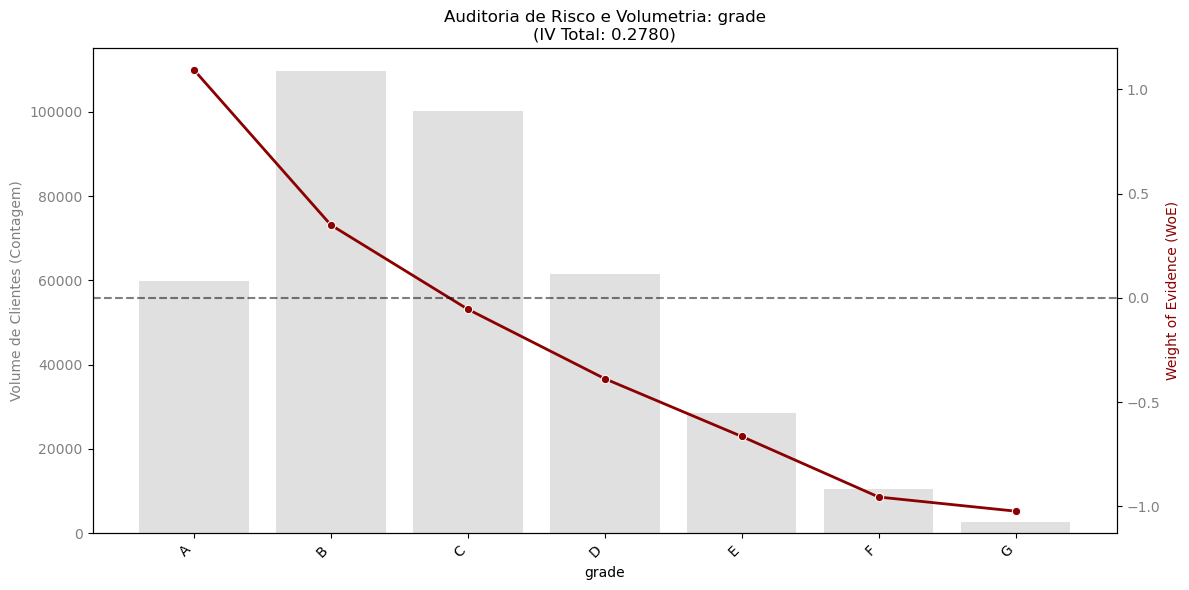


 STATUS: Gerando Laudo de Risco >>> HOME_OWNERSHIP <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


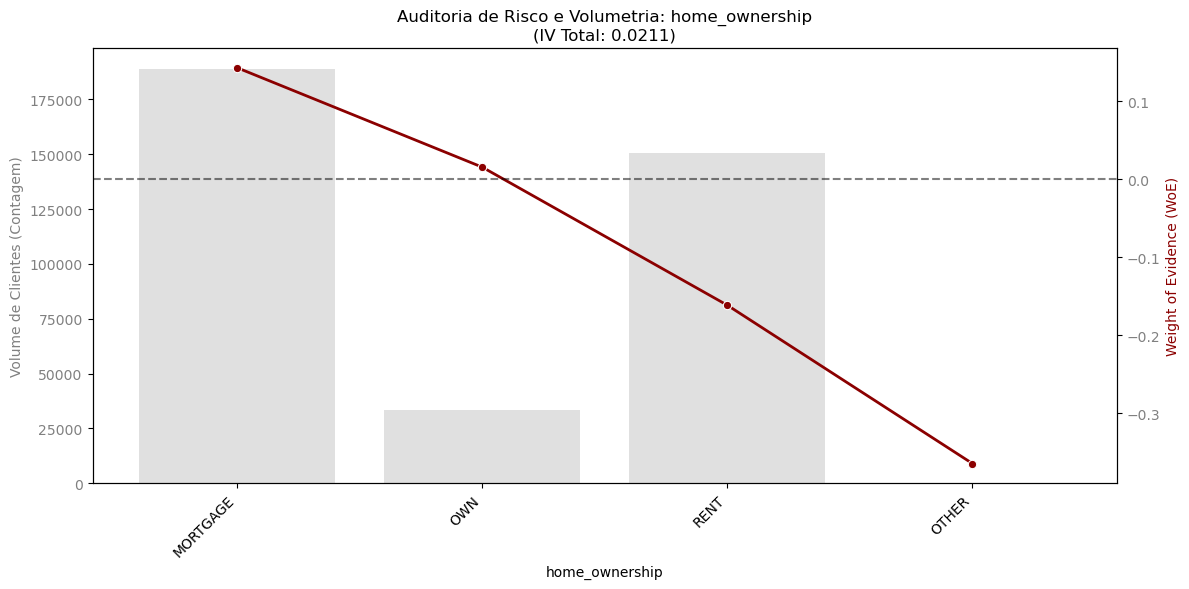


 STATUS: Gerando Laudo de Risco >>> PURPOSE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


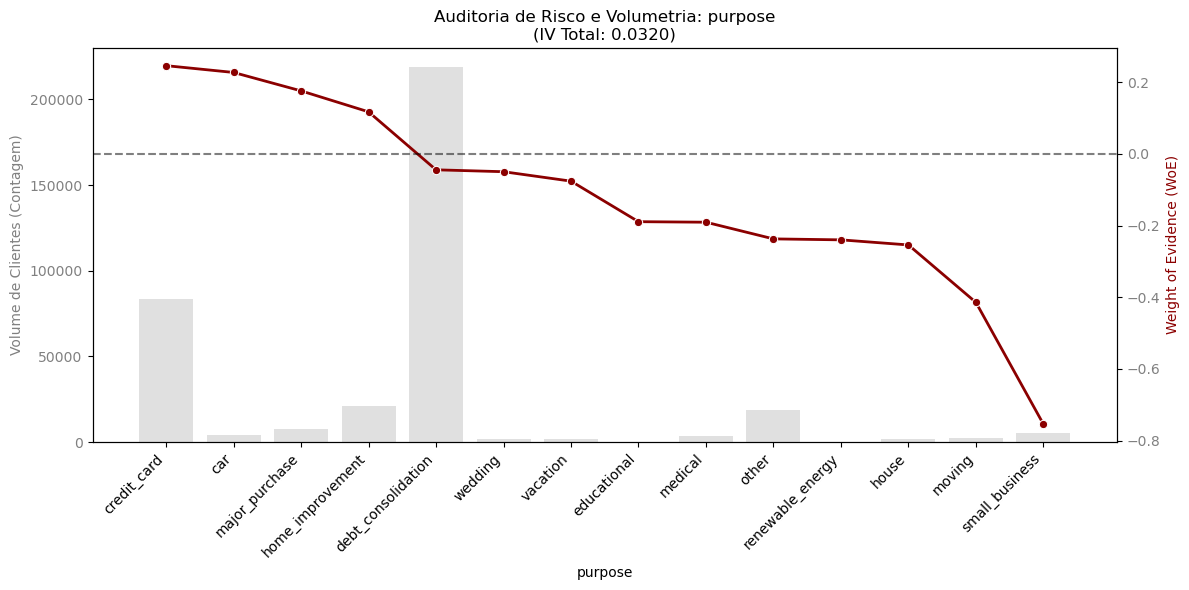


 STATUS: Gerando Laudo de Risco >>> VERIFICATION_STATUS <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


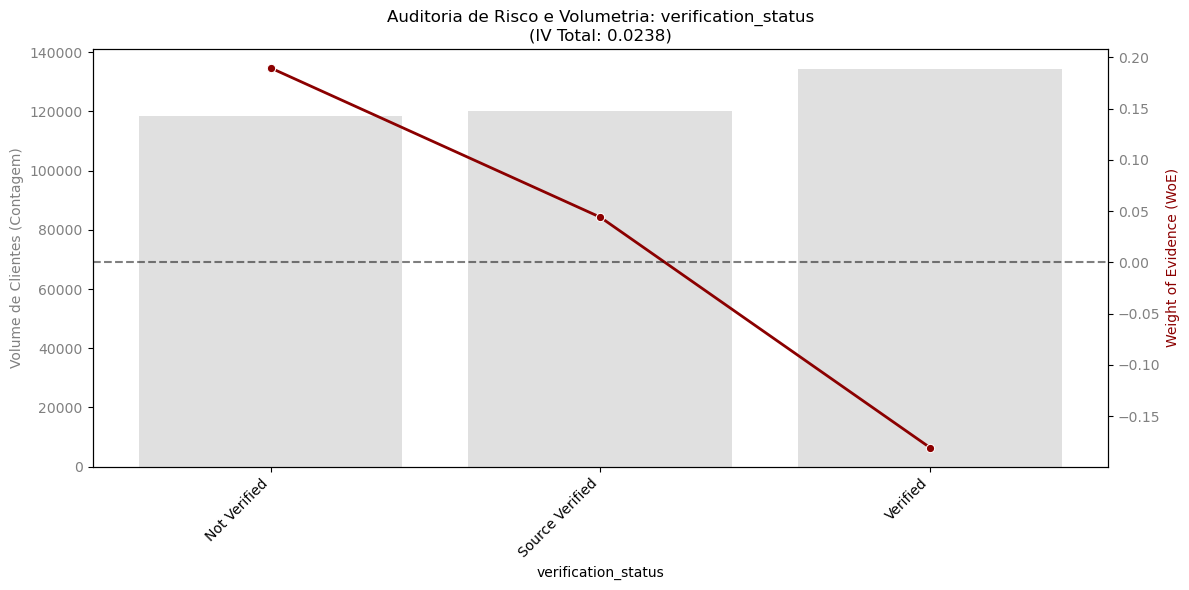


 STATUS: Gerando Laudo de Risco >>> FAIXA_RENDA <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


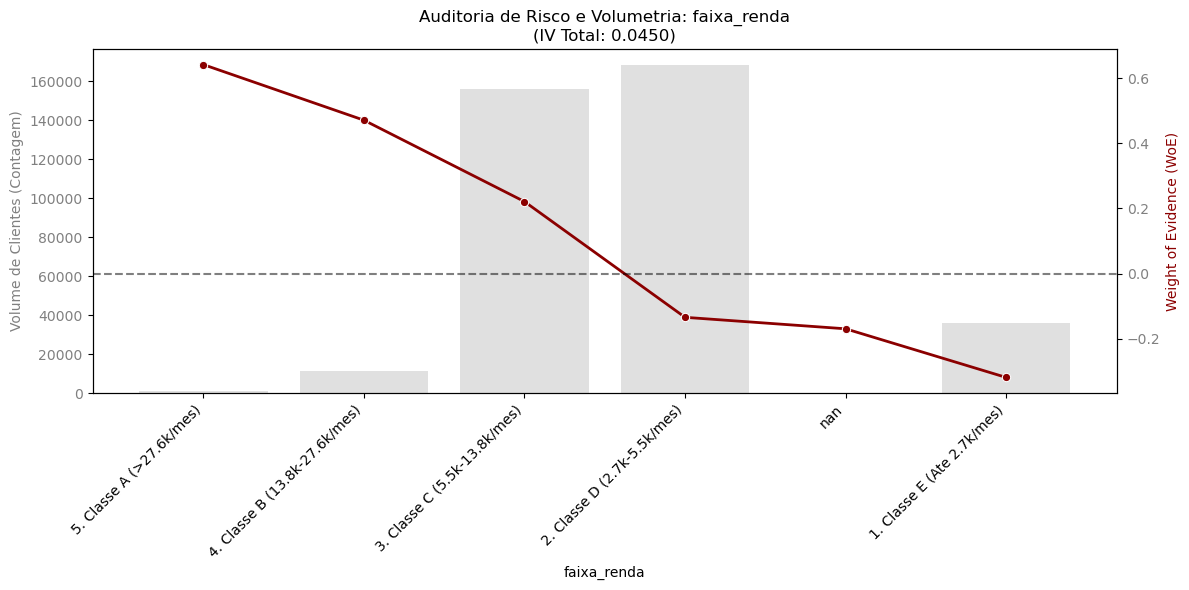


 STATUS: Gerando Laudo de Risco >>> FAIXA_DTI <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


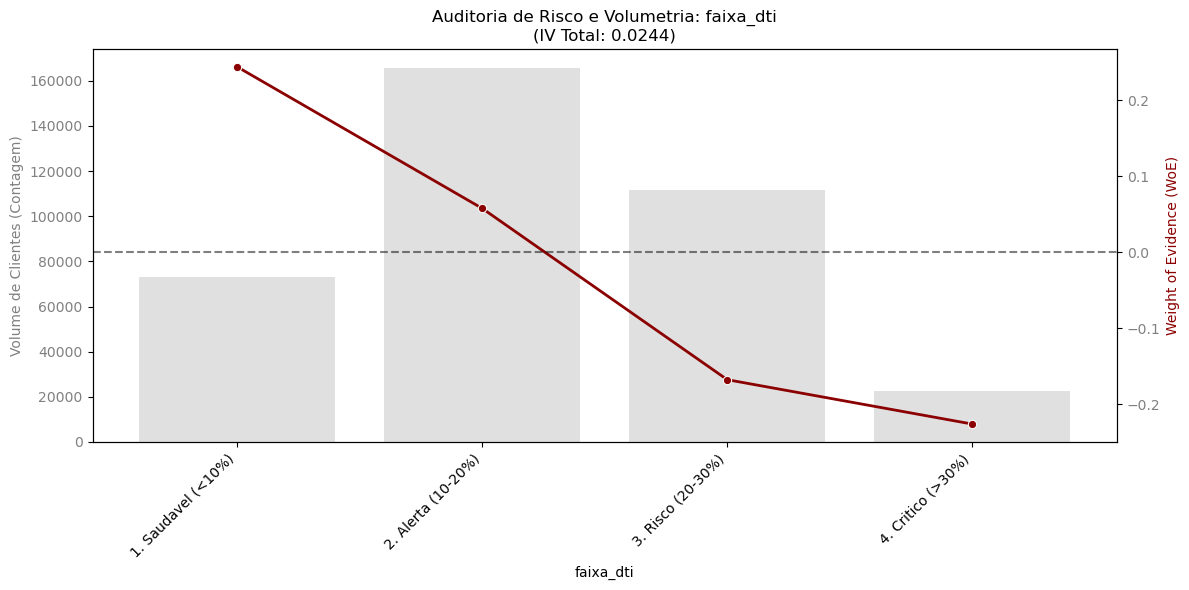

In [6]:
# ===================================================================
# CÉLULA 4: MOTOR DE AUDITORIA V2 (SCANNER VISUAL DE RISCO)
# ===================================================================
colunas_para_testar = [
    'grade', 
    'home_ownership', 
    'purpose', 
    'verification_status',
    'faixa_renda',  # A Inteligência da FGV Social
    'faixa_dti'     # O Risco de Alavancagem
]

print("STATUS: Iniciando o Scanner de Risco nas variáveis da esteira...\n")

for coluna in colunas_para_testar:
    if coluna in df_treino_woe.columns:
        print(f"\n{'='*70}")
        print(f" STATUS: Gerando Laudo de Risco >>> {coluna.upper()} <<<")
        print(f"{'='*70}")
        
        df_tabela_woe = calcular_woe_iv(df_treino_woe, coluna, 'good_bad_loan')
        auditar_tendencia_woe(df_tabela_woe, coluna)
    else:
        print(f"ALERTA: A variável '{coluna}' não foi encontrada.")

## 6. Matematização da Base (Injeção de Weight of Evidence)
Substituição definitiva dos atributos textuais ou contínuos pelos seus respectivos pesos de risco (WoE). 

**Fundamentos Matemáticos:**
1. **Equação do WoE:** Calculado através do logaritmo natural da proporção entre a distribuição de clientes bons e maus: $WoE = \ln(\%Bons / \%Maus)$.
2. **Linearização do Espaço:** A Regressão Logística atua melhor quando a relação entre os previsores e o *log-odds* do Target é linear. O WoE força essa linearidade de forma perfeita, lidando nativamente com *outliers* e *missing values* ocultos, mitigando distorções na otimização do gradiente.

In [7]:
# ===================================================================
# CÉLULA 5: INJEÇÃO DE PESOS DE RISCO TURBINADA (WoE)
# ===================================================================
print("STATUS: Iniciando injeção de pesos matemáticos (WoE) no Chassi V2...")

for col in colunas_para_testar:
    df_ref_woe = calcular_woe_iv(df_treino_woe, col, 'good_bad_loan')
    X_train = injetar_woe_na_base(X_train, df_ref_woe, col)
    X_test = injetar_woe_na_base(X_test, df_ref_woe, col)

print("STATUS: Sucesso. Base V2 transformada em puro risco matemático.")
display(X_train[[f"{c}_woe" for c in colunas_para_testar]].head())

STATUS: Iniciando injeção de pesos matemáticos (WoE) no Chassi V2...
STATUS: Sucesso. Base V2 transformada em puro risco matemático.


,grade_woe,home_ownership_woe,purpose_woe,verification_status_woe,faixa_renda_woe,faixa_dti_woe
427211,1.0938,0.1427,-0.0445,0.0440,0.2212,-0.1678
206088,-0.0548,0.1427,-0.0445,0.1896,0.2212,0.2438
136020,1.0938,0.1427,-0.0445,-0.1807,0.2212,0.0575
412305,-0.3881,-0.1617,-0.0445,0.0440,-0.1336,0.0575
36159,-0.0548,0.1427,-0.1892,-0.1807,0.2212,-0.1678


## 7. Treinamento Algorítmico e Auditoria de Coeficientes (Caixa Branca)
Calibração do algoritmo preditivo supervisionado. O modelo aprende a ponderar matematicamente as interações entre as variáveis de Risco (Grade, DTI, Renda) para maximizar a separação das classes.

**Fundamentos Estatísticos e Regulatórios:**
1. **Explicabilidade (Bacen):** Optamos pela Regressão Logística clássica em detrimento de algoritmos de "Caixa Preta" (como *XGBoost* ou *Redes Neurais*). A diretriz de Basileia exige que cada ponto de *Score* negado a um cliente possa ser matematicamente justificado.
2. **Análise de Intercepto e Pesos ($\beta$):** Extração dos coeficientes gerados no treinamento. Permite ao Comitê de Risco validar se as variáveis socioeconômicas introduzidas no V2 (Renda e Alavancagem) diluíram a dependência sistêmica de fatores isolados.

In [15]:
# ===================================================================
# CÉLULA 6: O CÉREBRO DO SCORECARD V2 (REGRESSÃO LOGÍSTICA)
# ===================================================================

colunas_woe_v2 = [f"{c}_woe" for c in colunas_para_testar]

print("STATUS: Iniciando treinamento do Modelo Campeão (V2)...")

modelo_v2 = LogisticRegression(max_iter=1000, random_state=42)
modelo_v2.fit(X_train[colunas_woe_v2], y_train)

print("STATUS: Sucesso. O motor V2 foi calibrado com Renda (FGV) e DTI.")

# Auditoria de Pesos
pesos_v2 = pd.DataFrame({
    'Variável_Sensor': colunas_woe_v2, 
    'Peso_Matemático': modelo_v2.coef_[0]
}).sort_values(by='Peso_Matemático', ascending=False)

print("\n--- RANKING DE IMPORTÂNCIA DO MODELO V2 ---")
display(pesos_v2)
# --- AUDITORIA PREDITIVA: GERANDO AS PROBABILIDADES ---
print("\nSTATUS: Extraindo probabilidades para a base cega (X_test)...")

# 1. O motor gera a probabilidade de Calote (Classe 0) e Lucro (Classe 1)
# Usamos o índice [:, 0] para pegar a Probabilidade de Calote para o P&L
probabilidade_calote = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 0]

# 2. Usamos o índice [:, 1] apenas para o cálculo estatístico do GINI
probabilidade_lucro = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 1]

from sklearn.metrics import roc_auc_score
auc_v2 = roc_auc_score(y_test, probabilidade_lucro)
gini_v2 = (auc_v2 * 2) - 1

print(f"LAUDO FINAL V2: GINI de {gini_v2*100:.2f}%")

STATUS: Iniciando treinamento do Modelo Campeão (V2)...
STATUS: Sucesso. O motor V2 foi calibrado com Renda (FGV) e DTI.

--- RANKING DE IMPORTÂNCIA DO MODELO V2 ---


,Variável_Sensor,Peso_Matemático
0,grade_woe,0.9043
4,faixa_renda_woe,0.8241
3,verification_status_woe,0.5342
1,home_ownership_woe,0.5251
2,purpose_woe,0.5108
5,faixa_dti_woe,0.4169



STATUS: Extraindo probabilidades para a base cega (X_test)...
LAUDO FINAL V2: GINI de 32.93%


## 8. Laudo de Estresse Matemático (Prevenção de Overfitting)
Auditoria fiduciária independente. Um modelo superajustado gera lucro no ambiente de desenvolvimento e falência generalizada no ambiente de produção.

**Fundamentos de Risco Quantitativo:**
1. **Estabilidade de Variância:** Medição do *Gap* entre o GINI da base de Treino (memória) e o GINI da base de Teste (realidade). Uma variação aceitável ($< 5\%$) prova que o modelo "aprendeu" os padrões de crédito ao invés de "decorar" o ruído do banco de dados.
2. **Coerência de Sinais:** Verificação obrigatória dos coeficientes da equação logística. Inversões de sinal matemático indicam colinearidade severa ou quebra da lógica de negócio (ex: o robô decidindo que ter "renda maior" aumenta o risco de calote).

In [16]:
# ===================================================================
# CÉLULA 7: AUDITORIA PREDITIVA (GINI DO V2)
# ===================================================================

print("STATUS: Extraindo probabilidades e auditando o poder preditivo...")

# O robô prevê o calote na base cega
probabilidades_calote = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 1]

# Calculamos as métricas de mercado
auc = roc_auc_score(y_test, probabilidades_calote)
gini = (auc * 2) - 1

print(f"{'='*50}")
print(f" STATUS: Auditoria Preditiva Concluída.")
print(f" Métrica AUC:  {auc:.4f}")
print(f" Métrica GINI: {gini:.4f} ({gini*100:.2f}%)")
print(f"{'='*50}")

# Gerando os Scores para a próxima etapa
X_test['Score_Final'] = calcular_score_final(probabilidades_calote)

STATUS: Extraindo probabilidades e auditando o poder preditivo...
 STATUS: Auditoria Preditiva Concluída.
 Métrica AUC:  0.6647
 Métrica GINI: 0.3293 (32.93%)


## 9. Laudo de Estresse Matemático (Prevenção de Overfitting)
Auditoria fiduciária independente. Um modelo superajustado gera lucro no ambiente de desenvolvimento e falência generalizada no ambiente de produção.

**Fundamentos de Risco Quantitativo:**
1. **Estabilidade de Variância:** Medição do *Gap* entre o GINI da base de Treino (memória) e o GINI da base de Teste (realidade). Uma variação aceitável ($< 5\%$) prova que o modelo "aprendeu" os padrões de crédito ao invés de "decorar" o ruído do banco de dados.
2. **Coerência de Sinais:** Verificação obrigatória dos coeficientes da equação logística. Inversões de sinal matemático indicam colinearidade severa ou quebra da lógica de negócio (ex: o robô decidindo que ter "renda maior" aumenta o risco de calote).

In [17]:
# ===================================================================
# AUDITORIA ESTATÍSTICA: A PROVA REAL DA MATEMÁTICA (BLINDADA)
# ===================================================================
print("STATUS: Iniciando Teste de Estresse Matemático...\n")

# 1. Geração Independente de Probabilidades (Evita NameError e Vazamento)
# Recalculamos as probabilidades aqui para garantir isolamento da auditoria
prob_treino_lucro = modelo_v2.predict_proba(X_train[colunas_woe_v2])[:, 1]
prob_teste_lucro = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 1] # <-- A vacina contra o erro

# 2. Cálculo das Métricas de Separação
gini_treino = (roc_auc_score(y_train, prob_treino_lucro) * 2) - 1
gini_teste = (roc_auc_score(y_test, prob_teste_lucro) * 2) - 1

# --- TESTE 1: AUDITORIA DE OVERFITTING ---
print(f"1. LAUDO DE OVERFITTING:")
print(f"   GINI no Treino (O que ele viu): {gini_treino*100:.2f}%")
print(f"   GINI no Teste (O que ele não viu): {gini_teste*100:.2f}%")
if abs(gini_treino - gini_teste) > 0.05:
    print("   -> ALERTA VERMELHO: O modelo está decorando dados (Overfitting)!\n")
else:
    print("   -> SINAL VERDE: A matemática está estável entre as bases.\n")

# --- TESTE 2: AUDITORIA DE SINAIS DOS COEFICIENTES ---
print(f"2. LAUDO DE DIREÇÃO MATEMÁTICA (COEFICIENTES):")
pesos_negativos = pesos_v2[pesos_v2['Peso_Matemático'] < 0]
if len(pesos_negativos) > 0:
    print(f"   -> ALERTA VERMELHO: O robô inverteu a lógica de risco destas variáveis:")
    display(pesos_negativos)
else:
    print("   -> SINAL VERDE: Todos os pesos seguem a mesma direção do WoE. A lógica está intacta.\n")

# --- TESTE 3: AUDITORIA DA DISTRIBUIÇÃO DA BASE ---
taxa_calote_real = 1 - y_train.mean()
print(f"3. LAUDO DE DISTRIBUIÇÃO DA CARTEIRA:")
print(f"   Taxa de Calote Real na Base de Treino: {taxa_calote_real*100:.2f}%")
if taxa_calote_real < 0.05 or taxa_calote_real > 0.50:
    print("   -> ALERTA: Base fortemente desbalanceada. O GINI pode estar distorcido.\n")
else:
    print("   -> SINAL VERDE: Distribuição de risco aceitável para o algoritmo.\n")

STATUS: Iniciando Teste de Estresse Matemático...

1. LAUDO DE OVERFITTING:
   GINI no Treino (O que ele viu): 32.02%
   GINI no Teste (O que ele não viu): 32.93%
   -> SINAL VERDE: A matemática está estável entre as bases.

2. LAUDO DE DIREÇÃO MATEMÁTICA (COEFICIENTES):
   -> SINAL VERDE: Todos os pesos seguem a mesma direção do WoE. A lógica está intacta.

3. LAUDO DE DISTRIBUIÇÃO DA CARTEIRA:
   Taxa de Calote Real na Base de Treino: 10.77%
   -> SINAL VERDE: Distribuição de risco aceitável para o algoritmo.



## 10. Laudo Visual Preditivo: Capacidade de Separação (ROC / GINI)
Tradução da performance do algoritmo em métricas globais de separação de classes, estabelecendo o teto de eficácia do Scorecard.

**Fundamentos Estatísticos:**
1. **Curva ROC (Receiver Operating Characteristic):** Plota a Taxa de Verdadeiros Positivos contra a Taxa de Falsos Positivos em diferentes limiares de corte (Thresholds).
2. **Coeficiente GINI:** Métrica de desigualdade aplicada à propensão de risco ($GINI = 2 \times AUC - 1$). Quanto mais o GINI se afasta de 0% (decisão aleatória equivalente ao cara ou coroa) e se aproxima de 100%, maior a capacidade do modelo de distinguir cirurgicamente um caloteiro de um cliente *Prime*.

STATUS: Gerando o Laudo Visual de Separação de Risco...



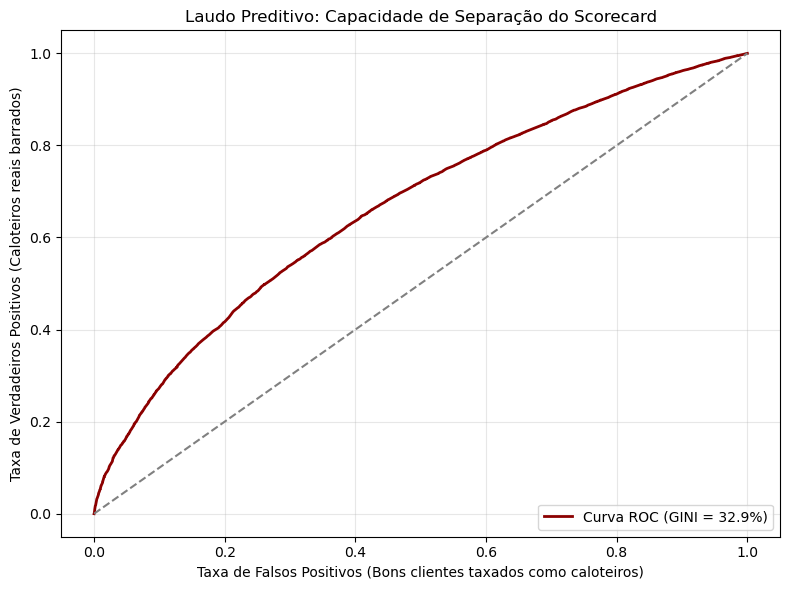

In [18]:
# ===================================================================
# CÉLULA 7.5: O LAUDO VISUAL DO COMITÊ (CURVA ROC)
# ===================================================================
print("STATUS: Gerando o Laudo Visual de Separação de Risco...\n")

# Chamamos a função limpa que você tem no src/plots_woe.py
auditar_curva_roc(y_test, probabilidades_calote, gini)

## 11. Fechamento de Caixa: O Impacto Financeiro (Loss Evitado)
O laudo final do Diretor. O GINI e o IV são convertidos em Reais (R$) através do *Backtesting* financeiro na base cega.

**Fundamentos de Business Intelligence (BI):**
1. **Matriz de Confusão Financeira (Crosstab):** Aplicação de uma política de corte por quartis (ex: reprovar sumariamente os clientes com *Score* enquadrado no percentil 25 mais baixo).
2. **Cálculo de *Loss* Evitado:** Isolamento dos "Verdadeiros Positivos" de risco (clientes reprovados pelo modelo que, historicamente, realmente deram calote). Multiplica-se este volume pelo ticket médio da perda (ex: R$ 10.000 por fraude/calote) para obter o Lucro Líquido Protegido atribuível exclusivamente à implementação deste algoritmo.

In [24]:
# ===================================================================
# CÉLULA 8: O LAUDO FINAL DO DIRETOR (LOSS EVITADO)
# ===================================================================
print("STATUS: Aplicando Política de Crédito e calculando Lucro...")

# 1. A Bifurcação (O Clone do Auditor)
df_comite_risco = X_test[['grade_woe', 'home_ownership_woe', 'Score_Final']].copy()
df_comite_risco['Calote_Real'] = y_test

# 2. Aplicamos o motor calibrado
df_comite_risco = aplicar_politica_decisao_quartis(df_comite_risco)

# 3. Cálculo do Loss Evitado (10k por calote barrado)
filtro_loss = (df_comite_risco['Decisao'] == 'REPROVADO') & (df_comite_risco['Calote_Real'] == 1)
clientes_barrados = df_comite_risco[filtro_loss].shape[0]
loss_evitado = clientes_barrados * 10000 

print(f"\n{'='*65}")
print(f" AUDITORIA FINAL DO V2: O modelo barrou {clientes_barrados} clientes .")
print(f" ESTIMATIVA DE LUCRO V2: R$ {loss_evitado:,.2f} em 'Loss' evitado.")
print(f"{'='*65}")

STATUS: Aplicando Política de Crédito e calculando Lucro...

 AUDITORIA FINAL DO V2: O modelo barrou 25452 clientes .
 ESTIMATIVA DE LUCRO V2: R$ 254,520,000.00 em 'Loss' evitado.


# ===================================================================
# 12. LAUDO EXECUTIVO: SIMULAÇÃO MACROECONÔMICA (STRESS TEST)
# ===================================================================
**Objetivo:** Provar para a Diretoria Comercial que o modelo V2 é dinâmico e defende o balanço patrimonial (P&L) em cenários de crise, aplicando o conceito de *Risk-Based Pricing* (Precificação Baseada em Risco).

### ⚙️ As Premissas da Tesouraria (Parâmetros do Teste)
Para que o algoritmo calcule o Valor Esperado (EV) em Reais e tome a decisão matemática de Aprovar ou Reprovar um CPF, o motor opera com as seguintes premissas travadas:
* **Ticket Médio de Crédito:** R$ 10.000,00 por cliente.
* **Taxa Cobrada do Cliente:** 35% ao ano (Pré-fixada).
* **Custo Administrativo (Spread Base):** 5% ao ano.
* **Custo de Captação (Funding):** Taxa Selic Variante.

### 📊 A Dinâmica do Esmagamento de Margem (*Margin Squeeze*)
Como a taxa do cliente está travada em 35%, o custo da Selic dita o apetite de risco do algoritmo:

* **Cenário 1 (Selic 7.0% - Dinheiro Barato):** O custo de captação é baixo. A margem de lucro do banco é alta (Spread de 23%). O modelo relaxa o corte, aprova mais CPFs com DTI apertado e maximiza o *Market Share*.
* **Cenário 2 (Selic 10.5% - Operação Normal):** Cenário base de calibração histórica.
* **Cenário 3 (Selic 14.0% - Dinheiro Caro / Crise):** O *Funding* fica caríssimo e engole a margem de lucro (Spread cai para 16%). O algoritmo percebe que o Risco x Retorno não compensa e **endurece a régua de aprovação automaticamente**, barrando mais clientes para evitar que a carteira feche no vermelho.

In [22]:
print("STATUS: Executando Teste de Estresse Macroeconômico (Copom)...\n")

# 1. O CONTRATO DE CENÁRIOS (Dicionário Blindado)
# Impossível desalinhar o nome da taxa. A governança visual é perfeita.
cenarios_macro = {
    "Otimista (Selic 7.0%)": 0.07,
    "Base (Selic 10.5%)": 0.105,
    "Estresse (Selic 14.0%)": 0.14
}

resultados = []

# 2. O LOOP EXECUTIVO (Usando .items() no lugar do zip)
# Ele desempacota a Chave (nome) e o Valor (taxa) do nosso Dicionário automaticamente.
for nome, taxa in cenarios_macro.items():
    
    lucro, aprovacao, reprovados = simular_politica_selic(
        y_true=y_test, 
        prob_calote=probabilidade_calote, 
        selic_atual=taxa
    )
    
    resultados.append({
        'Cenário Econômico': nome,
        'Selic (a.a.)': f"{taxa*100:.1f}%",
        'Taxa de Aprovação': f"{aprovacao*100:.1f}%",
        'Clientes Reprovados': reprovados,
        'Lucro Líquido Final': f"R$ {lucro:,.2f}"
    })

# O Laudo do Diretor
df_resultados_macro = pd.DataFrame(resultados)

print(f"{'='*80}")
print(" AUDITORIA DE TESOURARIA: IMPACTO DA SELIC NA POLÍTICA DE CRÉDITO")
print(f"{'='*80}")
display(df_resultados_macro)

STATUS: Executando Teste de Estresse Macroeconômico (Copom)...

 AUDITORIA DE TESOURARIA: IMPACTO DA SELIC NA POLÍTICA DE CRÉDITO


,Cenário Econômico,Selic (a.a.),Taxa de Aprovação,Clientes Reprovados,Lucro Líquido Final
0,Otimista (Selic 7.0%),7.0%,91.0%,8414,"R$ 94,328,100.00"
1,Base (Selic 10.5%),10.5%,84.7%,14300,"R$ 68,260,750.00"
2,Estresse (Selic 14.0%),14.0%,74.3%,24000,"R$ 45,317,600.00"
